## Código base del modelo de degradación condicional a curva de SoC y temperatura ambiente

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor
from scipy.stats import gaussian_kde
import math
import matplotlib.pyplot as plt

In [2]:
# Funciones auxiliares
def log_a(a,x):
    y = np.log(x)/np.log(a)
    return y

def fill_with_nan(lst, desired_length):
    # Calculate how many NaN values need to be added
    nan_count = desired_length - len(lst)
    
    # Add NaN values to the list if necessary
    if nan_count > 0:
        lst.extend([math.nan] * nan_count)
    
    return lst

def temp_factor(temp):
        # definimos los coeficientes ya fiteados
        coef = np.array([-1.25736777e-11,  4.79001576e-10,  5.01975901e-08,  5.04209738e-07,
                -3.61735311e-04,  1.12614410e-02,  1.02131291e+00])
        # creamos la funcion generadora de factores por temperatura
        polynomial = np.poly1d(coef)
        # Calculamos el factor ponderador por temperatura
        factor = np.clip(polynomial(temp),0,1)
        return factor

### Extraemos los datos para parametrizar el modelo de la batería

In [4]:
# Obtenemos los valores de SOH del ground truth
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/uncertainty_characterization/stanford_cell_SOH.csv"
SOH_gt_df = pd.read_csv(path,delimiter=';',)
SOH_gt_df = SOH_gt_df.drop(index=0).reset_index(drop=True)

# definimos el nombre de cada cada tanda de degradación
path = os.path.join('D:/dataset_stanford', 'W9')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))
SOH_gt_df["files"] = files

# Obtenemos los subciclos realizados para cada celda
path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/uncertainty_characterization/stanford_cell_cycles.csv"
subcycles_gt_df = pd.read_csv(path,delimiter=';',)
subcycles_gt_df["files"] = files

In [4]:
# change the column titles of subcycles_gt_df by adding a subfix "_cycles"
subcycles_gt_df.columns = [col + "_cycles" for col in subcycles_gt_df.columns]
# change the column titles of SOH_gt_df by adding a subfix "_SOH"
SOH_gt_df.columns = [col + "_SOH" for col in SOH_gt_df.columns]
# merch both df
gt_df = pd.merge(SOH_gt_df, subcycles_gt_df, left_on="files_SOH", right_on="files_cycles", how="left")


In [7]:
# change gt_df to only keep the columns "W9_cycles", "W10_cycles", "W9_SOH", "W10_SOH", "files_cycles"
gt_df = gt_df[["W9_cycles", "W10_cycles", "W9_SOH", "W10_SOH", "files_cycles"]]

In [ ]:
# change the column title "files_cycles" to "files"
gt_df = gt_df.rename(columns={"files_cycles": "files"})
gt_df

,W9_cycles,W10_cycles,W9_SOH,W10_SOH,files
0,25,25,0.991863,0.993366,C1.csv
1,50,50,0.978999,0.979203,C2.csv
2,47,47,0.968954,0.966177,C3.csv
3,22,24,0.955331,0.954701,C4.csv
4,1,2,0.952444,0.952462,C5.csv
5,1,3,0.943475,0.943691,C6.csv
6,4,8,0.935122,0.935875,C7.csv
7,29,29,0.932702,0.933866,C8.csv
8,37,37,0.932778,0.933686,C9.csv
9,25,25,0.930311,0.930635,C10.csv


In [11]:
# save the gt_df in a csv file
gt_df.to_csv("C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/stanford_cell_gt.csv", index=False, sep=";")

In [31]:
# import stanford_cell_gt.csv
gt_df = pd.read_csv("C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/stanford_cell_gt.csv", delimiter=';')

for cell in ["W9", "W10"]:
    
    cell_name = cell
    SR_0 = 100 # soc range de un ciclo equivalente 
    SR = 80 # soc range de los subciclos del dataset
    acc_subc = 0

    eq_cycles = [] # ciclos equivalentes a cada tanda de degradación
    eq_cycles80 = [] # ciclos equivalentes hasta el SOH=80% por cada tanda acumulada
    acc_eq_cycles = [] # ciclos equivalentes acumulados a cada tanda de degradación

    for idx,subcycle in enumerate(gt_df[cell_name+"_cycles"].values):
        # calculamos los ciclos equivalentes de cada tanda de degradación
        eq_cycle = subcycle*(SR/SR_0)
        eq_cycles.append(eq_cycle)
        acc_subc += eq_cycle
        acc_eq_cycles.append(acc_subc)

        # calculamos la tasa de degradación para cada tanda acumulada
        EOL_0 = gt_df[cell_name+"_SOH"].values[idx]
        eta_0 = EOL_0**(1/acc_subc)
        eq_cycle08 = 1/log_a(0.8,eta_0)
        eq_cycles80.append(eq_cycle08)

    gt_df[cell_name+"_eqcycles"] = eq_cycles # ciclos equiv hasta el SOH=80% por cada tanda acumulada
    gt_df[cell_name+"_acceqcycles"] = acc_eq_cycles # ciclos equiv acumulados hasta el SOH=80% por cada tanda acumulada
    gt_df[cell_name+"_eqcycles80"] = eq_cycles80 # ciclos equiv hasta el SOH=80% por cada tanda acumulada

### Creamos el modelo de la batería

In [ ]:
class BatteryModel:

    def __init__(self, Qmax=4.850, degradation_percentage=0.8, life_cycles=650, degradation_data=None):
        
        self.parameters = {
            "Qmax": Qmax,  # Carga nominal (Ah)
            "degradation_percentage": degradation_percentage,  # Por ejemplo, 80% de degradación
            "life_cycles": life_cycles,  # Por ejemplo, 1000 ciclos de vida
            "degradation_data": degradation_data if degradation_data else {
                "100-0":        [1.00000],
                "100-25":       [0.78750],
                "75-0":         [1.12525],
                "100-50":       [0.43750],
                "75-25":        [0.68750],
                "50-0":         [1.03125],
                "100-75":       [0.40625],
                "75-50":        [0.29700],
                "62.5-37.5":    [0.28125],
                "50-25":        [0.62500],
                "25-0":         [1.00000],
            },
        }
        self.memoria_soc = []  # Inicialización de memoria SOC vacía
        self.setup_knn()  # Configura el modelo k-NN
        self.set_kde()

    def setup_knn(self):
        # Preparar los datos para el modelo k-NN
        X = []
        y = []

        for sr, factors in self.parameters["degradation_data"].items():
            sr_range = [float(x) for x in sr.split("-")]
            sr_numeric = sr_range[0] - sr_range[1]  # SR
            asr_numeric = sum(sr_range) / 2  # ASR
            for degradation_percentage, factor in zip([0.8], factors):
                X.append([asr_numeric, sr_numeric, degradation_percentage])
                y.append(factor)

        # Convertir a numpy arrays
        X = np.array(X)
        y = np.array(y)

        # Entrenar el modelo k-NN
        self.knn = KNeighborsRegressor(n_neighbors=3, weights="distance")
        self.knn.fit(X, y)  # Entrenar el modelo k-NN

        print("modelo de celda seteado. Tabla de degradación: ",self.parameters["degradation_data"])

    def set_kde(self):
            path = "C:/Users/Bruno/OneDrive - Universidad de Chile/BGMG/CASE/git_repositories/degradation_model/uncertainty_characterization/eta_values_sorted.csv"
            eta_values = pd.read_csv(path,delimiter=',',header=None)
            eta_values = eta_values.values.flatten()
            self.kde = gaussian_kde(eta_values)
            print("KDE es been setted")
            # return(kde)
            
    def get_factor(self, soc, temp):
            # Obtenermos el SSR y el ASSR
            ssr = max(soc) - min(soc)
            assr = np.mean(soc)

            # Obtenemos el factor para ponderar los ciclos
            knn_factor = self.knn.predict(
                np.array([[assr, ssr, self.parameters["degradation_percentage"]]])
            )

            # definimos los ciclos del KNN
            cycles_0 = self.parameters["life_cycles"]
            cycles_k = knn_factor * cycles_0

            # definimos los ciclos en función de la temperatura
            t_factor = temp_factor(temp)
            cycles_k_ = cycles_k * t_factor

            # definimos el eta con incertidumbre
            noise = self.kde.resample(1)[0][0] - 0.999161393145505 
            etak = 0.8**(1/cycles_k_) + noise 
            etak = np.clip(etak,0.9882437541053815,1) # definimos limites porque el ruido puede generar valores demasiados extremos que no son reales
            return etak

### Agregamos el dataset para hacer un ejemplo de uso

In [20]:
dC_w10_standford_values = pd.read_csv("dC_w10_standford_values.csv", header=None, delimiter=",")
dC_w10_standford_values2 = dC_w10_standford_values.values.flatten()

In [37]:
np.sum(gt_df["W9_eqcycles80"].values)

np.float64(8061.897702614246)

In [39]:
# Define the path to the dataset and list all files in the directory
path = os.path.join('D:/dataset_stanford', 'W10')
files = os.listdir(path)
files.sort(key=lambda x: int(x[1 : x.find(".")]))  # Sort files based on numeric values in their names
files.remove('C7.csv')  # This file is not used in the analysis

# Initialize the BatteryModel
# parametrizamos el modelo con la celda W9 y lo probamos con la celda W10
battery_model = BatteryModel(Qmax=4.850,life_cycles=gt_df["W9_eqcycles80"].values[-1]) 

# Inner loop to iterate through multiple runs within each simulation (N defines the number of runs)
N = 9
i = 1
eq_cycle_count = 0  # Counter for equivalent cycles simulated
total_eq_cycle_count = 273  # Total equivalent cycles to simulate
total_soh_values = pd.DataFrame()  # DataFrame to store SOH (State of Health) values for each run

while i <= N:
    current_Q = battery_model.parameters["Qmax"]  # Initial maximum capacity of the battery
    Q_values = [current_Q]  # List to store capacity values over time

    # Load the dataset for a specific file (e.g., "C1.csv") just to select relevant columns
    file_path = os.path.join(path, "C1.csv")
    columns_to_select = ["step_ind", "SoC"]
    df = pd.read_csv(file_path, usecols=columns_to_select)

    # Variables for the equivalent cycle calculation method
    dsoc_new = 0  # Change in SoC (State of Charge)
    soc_acc_new = 0  # Accumulated SoC change
    soc_inst_eqcycle_new = df.SoC.values[0] * 100  # Initial SoC in percentage
    soc_counting_eqcycle_new = [soc_inst_eqcycle_new]  # List to track SoC changes
    step_counting_eqcycle_new = [df.step_ind.values[0]]  # List to track step indices
    eqcycle_SoH_values_new = []  # List to store SOH values for equivalent cycles

    # Variables for ground truth (GT) SOH
    gt_idx = 0  # Index for ground truth SOH
    gt_soh_values = [1]  # Initial ground truth SOH value (normalized to 1)
    gt_soh_idx = [gt_idx]  # List to track ground truth SOH indices

    # Iterate through all delta capacity values (dC_w10_standford_values2)
    for dc in dC_w10_standford_values2:
        dsoc_new = dc / current_Q  # Calculate change in SoC based on delta capacity
        soc_inst_eqcycle_new += dsoc_new  # Update the instantaneous SoC

        # Ensure SoC stays within valid bounds (0% to 100%)
        if soc_inst_eqcycle_new >= 100:
            soc_inst_eqcycle_new = 100
        elif soc_inst_eqcycle_new < 0:
            soc_inst_eqcycle_new = 0

        # Implementation of the equivalent cycle method
        if dsoc_new < 0:  # Only consider discharging events
            soc_acc_new += dsoc_new  # Accumulate SoC changes
            soc_counting_eqcycle_new.append(soc_inst_eqcycle_new)  # Track SoC changes

        # Check if an equivalent cycle is completed
        if -100 >= soc_acc_new:
            eta_k_eqcycle_new = battery_model.get_factor(soc_counting_eqcycle_new, 25)  # Get degradation factor
            current_Q *= eta_k_eqcycle_new[0]  # Update the current capacity based on degradation
            soc_acc_new = 0  # Reset accumulated SoC
            soc_counting_eqcycle_new = []  # Reset SoC tracking
            Q_values.append(current_Q)  # Append the updated capacity
            eq_cycle_count += 1  # Increment the equivalent cycle count

            # Break the loop if the total equivalent cycle count is exceeded
            if eq_cycle_count > total_eq_cycle_count:
                eq_cycle_count = 0
                break

    # Fill the Q_values list with NaN to ensure consistent length
    Q_values = fill_with_nan(Q_values, 450)
    Q_values = np.array(Q_values)
    SOH_values = Q_values / battery_model.parameters["Qmax"]  # Calculate SOH as a fraction of the initial capacity

    total_soh_values[i] = SOH_values  # Store SOH values for the current run
    i += 1

# Save the SOH values to a CSV file
filename = "SOH_values.csv"
print(filename)
# total_soh_values.to_csv(filename, index=False)


modelo de celda seteado. Tabla de degradación:  {'100-0': [1.0], '100-25': [0.7875], '75-0': [1.12525], '100-50': [0.4375], '75-25': [0.6875], '50-0': [1.03125], '100-75': [0.40625], '75-50': [0.297], '62.5-37.5': [0.28125], '50-25': [0.625], '25-0': [1.0]}
KDE es been setted
SOH_values.csv


### Extraemos la media y desviación estándar para hacer Monte Carlo

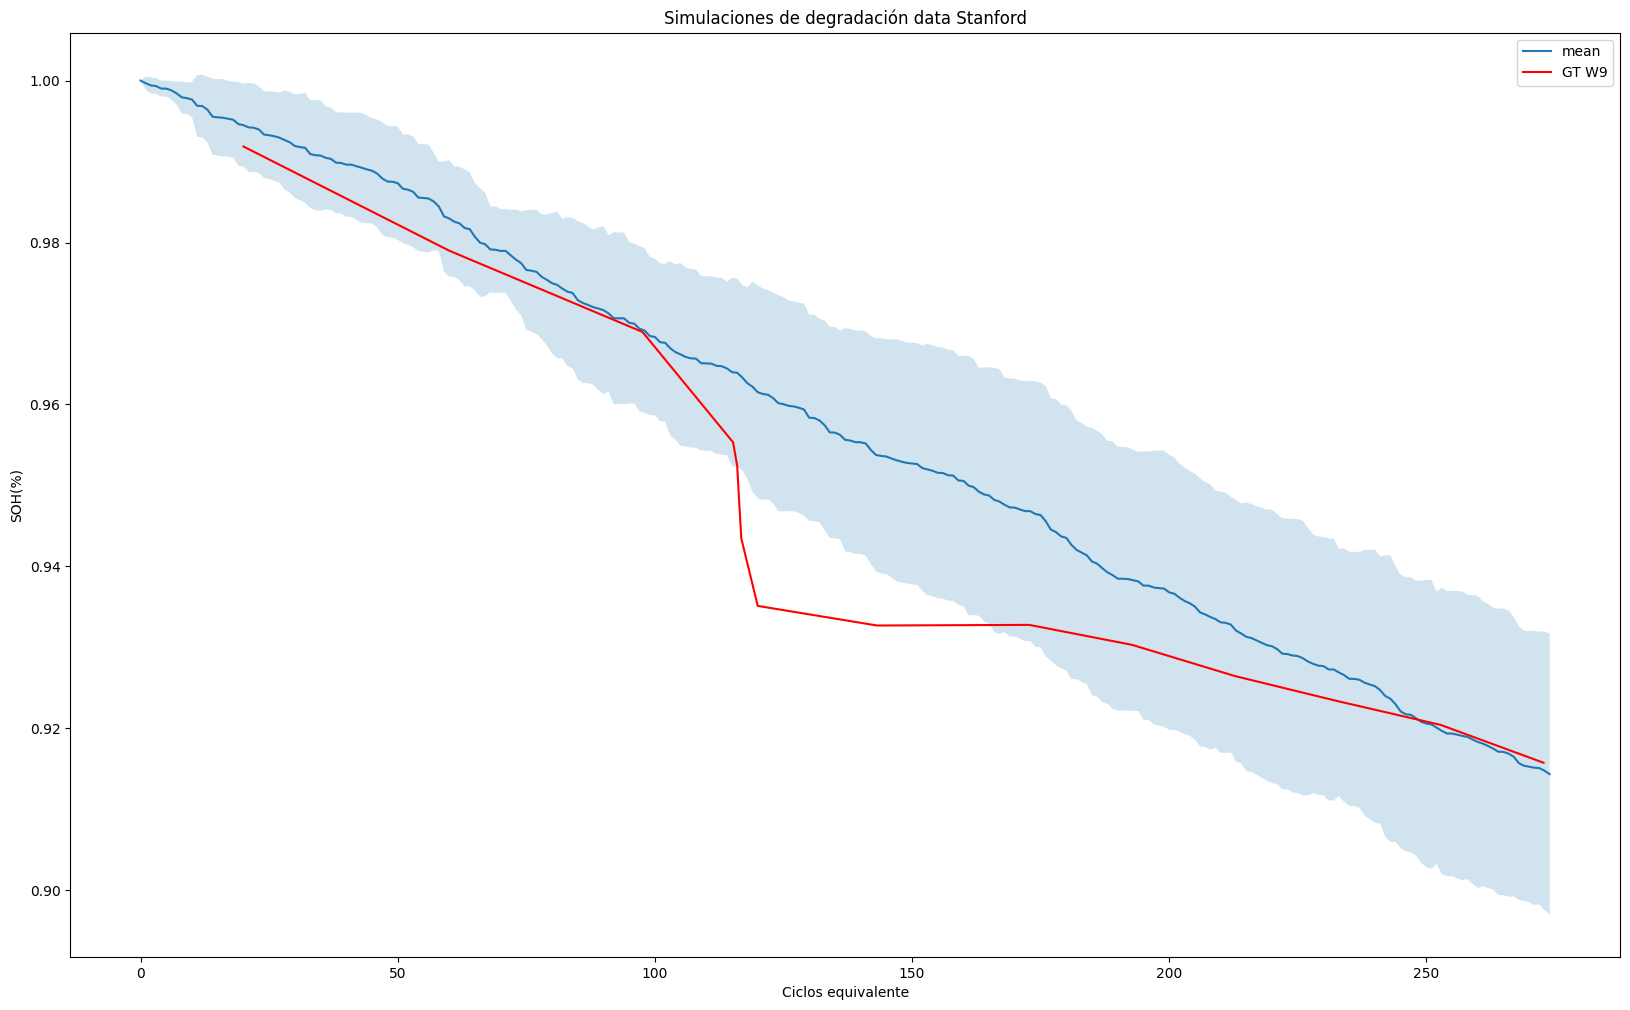

In [40]:
# Get the mean and standard deviation of the SOH values
SOH_df = total_soh_values.iloc[:, :N]  # Select only the columns from 1 to N (number of simulations)
SOH_df['mean'] = SOH_df.mean(axis=1)
SOH_df['std'] = SOH_df.std(axis=1)

axis = np.arange(len(SOH_df['std']))

# Plot the simulations results
plt.figure(figsize=(20, 12))
plt.plot(SOH_df['mean'], label='mean')
plt.fill_between(axis, SOH_df['mean'] - 1.5 * SOH_df['std'], SOH_df['mean'] + 1.5 * SOH_df['std'], alpha=0.2)

# use gt_df to plot the GT of the W10 cell, the x values are the equivalent cycles and the y values are the SOH values
plt.plot(gt_df["W9_acceqcycles"].values, gt_df["W9_SOH"].values, label="GT W9", color="red", linewidth=1.5)


plt.title("Simulaciones de degradación data Stanford")
plt.xlabel("Ciclos equivalente")
plt.ylabel("SOH(%)")
plt.legend()
plt.show()
